<a href="https://colab.research.google.com/github/geonextgis/End-to-End-Deep-Learning/blob/main/01_ANN/03_Customer_Churn_Prediction_using_ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Customer Churn Prediction using ANN**

<img src="https://www.cleartouch.in/wp-content/uploads/2022/11/Customer-Churn.png">

## **Import Required Libraries**

In [50]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings("ignore")

sns.set_style("whitegrid")
print(tf.__version__)

2.15.0


## **Read the Data from Kaggle**

In [52]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [53]:
# Download the data from kaggle
!kaggle datasets download -d rjmanoj/credit-card-customer-churn-prediction

credit-card-customer-churn-prediction.zip: Skipping, found more recently modified local copy (use --force to force download)


In [54]:
# Extract the data from Zipfile
import zipfile
zipref = zipfile.ZipFile("/content/credit-card-customer-churn-prediction.zip")
zipref.extractall("/content")
zipref.close()

In [55]:
# Read the data in a pandas dataframe
df = pd.read_csv("/content/Churn_Modelling.csv")
print(df.shape)
df.head()

(10000, 14)


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## **Data Preprocessing**

In [56]:
# Check for the missing values
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [57]:
# Check the information of all the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [58]:
# Drop the irrelevant columns (e.g., columns with 'object' datatype)
df.drop(columns=["RowNumber", "CustomerId", "Surname"], inplace=True)
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [59]:
# Check for the duplicated rows
df.duplicated().sum()

0

## **Exploratory Data Analysis**

In [60]:
# Check the number of people who Exited
df["Exited"].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

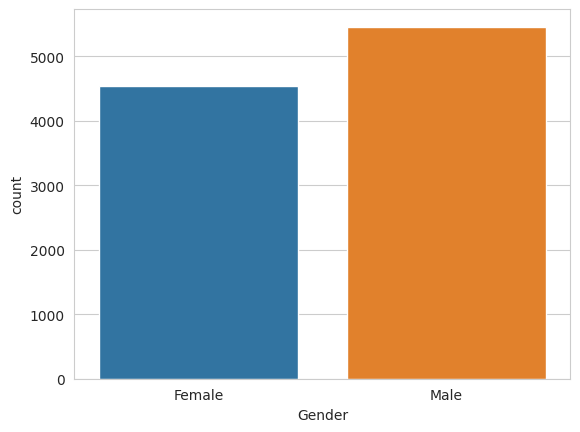

In [61]:
# Plot the categorical variables
sns.countplot(x=df["Gender"], hue=df["Gender"])
plt.show()

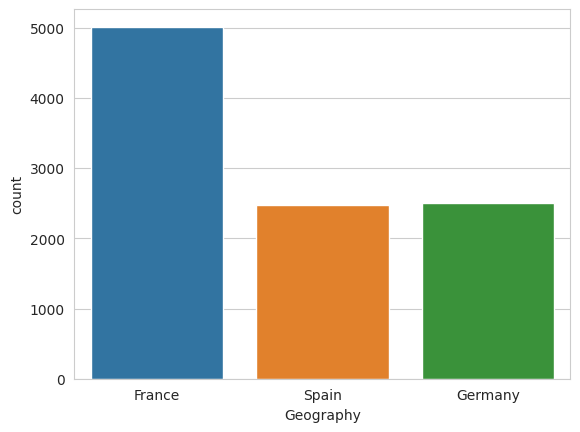

In [62]:
sns.countplot(x=df["Geography"], hue=df["Geography"])
plt.show()

## **One Hot Encoding**

In [63]:
# Apply One Hot Encoding on Categorical columns
df = pd.get_dummies(df, columns=["Geography", "Gender"], drop_first=True, dtype=int)
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


## **Train Test Split**

In [64]:
X_train, X_test, y_train, y_test = train_test_split(df.drop("Exited", axis=1),
                                                    df["Exited"],
                                                    test_size=0.2,
                                                    random_state=0)
X_train.shape, X_test.shape

((8000, 11), (2000, 11))

## **Feature Scaling**

In [65]:
# Create an object of the StandardScaler class
scaler = StandardScaler()

# Fit the training data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [66]:
# Convert the scaled array into a pandas dataframe
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [67]:
print(X_train_scaled.shape)
X_train_scaled.head()

(8000, 11)


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
0,0.169582,-0.464608,0.006661,-1.215717,0.809503,0.642595,-1.032270,1.106432,-0.569844,1.743090,-1.091687
1,-2.304559,0.301026,-1.377440,-0.006312,-0.921591,0.642595,0.968738,-0.748664,1.754865,-0.573694,0.916013
2,-1.191196,-0.943129,-1.031415,0.579935,-0.921591,0.642595,-1.032270,1.485335,-0.569844,-0.573694,-1.091687
3,0.035566,0.109617,0.006661,0.473128,-0.921591,0.642595,-1.032270,1.276528,-0.569844,1.743090,0.916013
4,2.056114,1.736588,1.044737,0.810193,0.809503,0.642595,0.968738,0.558378,-0.569844,1.743090,-1.091687


## **Build an Artifical Neural Network Architecture**

In [68]:
# Instantiate a Sequential model
model = Sequential()

# Add two Dense layer with 11 nodes into the Sequential Model
model.add(Dense(11, activation="relu", input_dim=11))
model.add(Dense(11, activation="relu"))

# Add another layer for the output with a single node
model.add(Dense(1, activation="sigmoid"))

In [69]:
# Print the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 11)                132       
                                                                 
 dense_4 (Dense)             (None, 11)                132       
                                                                 
 dense_5 (Dense)             (None, 1)                 12        
                                                                 
Total params: 276 (1.08 KB)
Trainable params: 276 (1.08 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [70]:
# Compile the model
model.compile(loss="binary_crossentropy", optimizer="Adam", metrics=["accuracy"])

In [71]:
# Fit the training data
history = model.fit(X_train_scaled, y_train, epochs=100, validation_split=0.2)

Epoch 1/100
200/200 [==============================] - 1s 3ms/step - loss: 0.5620 - accuracy: 0.7803 - val_loss: 0.4891 - val_accuracy: 0.7969
Epoch 2/100
200/200 [==============================] - 0s 2ms/step - loss: 0.4654 - accuracy: 0.7962 - val_loss: 0.4467 - val_accuracy: 0.7981
Epoch 3/100
200/200 [==============================] - 0s 2ms/step - loss: 0.4365 - accuracy: 0.8019 - val_loss: 0.4285 - val_accuracy: 0.8188
Epoch 4/100
200/200 [==============================] - 0s 2ms/step - loss: 0.4215 - accuracy: 0.8123 - val_loss: 0.4167 - val_accuracy: 0.8231
Epoch 5/100
200/200 [==============================] - 1s 3ms/step - loss: 0.4082 - accuracy: 0.8231 - val_loss: 0.4044 - val_accuracy: 0.8275
Epoch 6/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3915 - accuracy: 0.8352 - val_loss: 0.3872 - val_accuracy: 0.8388
Epoch 7/100
200/200 [==============================] - 1s 3ms/step - loss: 0.3737 - accuracy: 0.8448 - val_loss: 0.3741 - val_accuracy: 0.8506

In [72]:
# Check all 132 weights of the first layer
model.layers[0].get_weights()[0]

array([[ 0.15098783,  0.42795718, -0.44670796, -0.13438585,  0.1282706 ,
        -0.1392383 ,  0.01940327, -0.24896495, -0.14255118, -0.07671957,
         0.1143075 ],
       [ 1.0343529 , -0.5758534 , -0.72108614,  1.0247022 , -0.49793917,
         0.94226474,  0.08936888,  0.58117527, -0.17826687, -0.76871294,
         0.03019491],
       [ 0.26136374,  0.07306026,  0.0867313 , -0.10671916,  0.0212857 ,
        -0.06214297,  0.21264999, -0.00797634, -0.05900922, -0.05883336,
         0.31706157],
       [ 0.41639066, -0.88446784,  0.20194153, -0.34434888, -0.04129669,
        -0.35142258, -0.76278245,  0.4030318 ,  0.02200436, -0.01249816,
        -0.6137056 ],
       [ 0.07964716, -0.0159721 ,  0.02448821, -0.8808941 , -0.6317986 ,
         0.00408209, -0.247288  ,  0.5660258 ,  1.3757888 , -0.08679083,
         0.89153606],
       [ 0.32008478, -0.26714492,  0.034832  , -0.11195021,  0.5272863 ,
        -0.15341839,  0.2726126 , -0.4550924 ,  0.02827217, -0.07895002,
         0.102

In [73]:
# Check all the weights of the second layer
model.layers[1].get_weights()

[array([[-0.34868786, -0.08333673, -0.33720568, -0.8692715 ,  0.40824   ,
          0.09369075,  0.56626743, -0.00634142,  0.9653627 ,  0.48395374,
         -0.38922334],
        [ 0.02128372,  0.3022461 ,  0.5863694 ,  0.02120238,  0.18344009,
         -0.3827535 , -0.17378637, -0.23291722, -0.29562446, -2.3495514 ,
          0.42297226],
        [-0.23640113,  0.3822008 ,  0.47568312, -0.7100968 , -0.02786669,
         -0.45695066, -0.34344327, -0.34562835, -0.01004862, -0.12011429,
          0.03183934],
        [-0.37343088, -0.5806033 , -0.18364331,  0.08736172, -0.46526554,
          0.03514032, -0.43999237,  0.6832042 , -0.34765735, -0.4673171 ,
         -0.5388177 ],
        [ 0.57558393,  0.3428979 ,  0.5789726 , -0.63738066, -0.1491769 ,
         -0.68095315, -0.6810598 , -0.05438976,  0.05021827,  0.03026483,
          0.38225728],
        [-0.03790463, -0.12755415,  0.7049648 ,  0.11969833,  0.22446315,
         -0.25333345, -0.2603852 , -0.9294443 ,  0.7280147 , -0.1583708

In [74]:
# Check all the weights of the last layer
model.layers[2].get_weights()

[array([[-0.496392  ],
        [-0.6579251 ],
        [ 0.938073  ],
        [-1.547584  ],
        [-0.44470963],
        [ 1.3204832 ],
        [ 0.94226557],
        [ 1.2423327 ],
        [-0.60826856],
        [ 1.6983931 ],
        [-0.6082202 ]], dtype=float32),
 array([0.11951242], dtype=float32)]

## **Predict the Test Data**

In [75]:
y_pred = model.predict(X_test_scaled)
y_pred

63/63 [==============================] - 0s 1ms/step


array([[0.22163233],
       [0.33144286],
       [0.10755729],
       ...,
       [0.21103634],
       [0.16342525],
       [0.13854596]], dtype=float32)

In [76]:
# Convert the predicted probability into binary classes
# Assume a threshold value
threshold = 0.5

y_pred = np.where(y_pred > threshold, 1, 0)
y_pred

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

## **Accuracy Assessment**

In [77]:
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.8555


## **Plot the Training and Validation Loss**

In [78]:
# Print the key names of the history dictionary
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

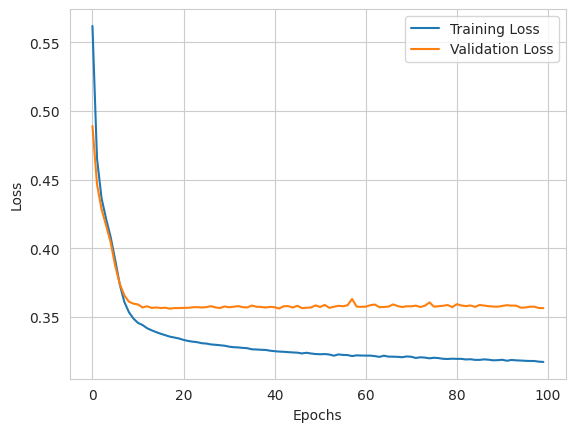

In [79]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

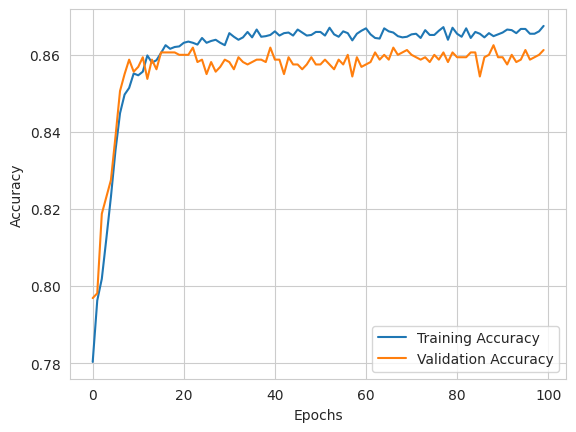

In [80]:
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()